In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/metrics_by_scenario.csv', encoding='ISO-8859-1')
data['model'] = data['model'].map({'naÃ¯ve_bayes': 'naive_bayes'}).fillna(data['model'])
data.head()

,model,dataset,metric,original,smote,threshold
0,adaboost,abalone,accuracy,0.7440,0.7440,0.7440
1,adaboost,abalone,auc_score,0.8545,0.8545,0.8545
2,adaboost,abalone,f1_score,0.3851,0.3851,0.3851
3,adaboost,abalone,precision,0.2538,0.2538,0.2538
4,adaboost,abalone,recall,0.7976,0.7976,0.7976


In [3]:
df_long = data.melt(id_vars=['model', 'dataset', 'metric'], var_name='Group', value_name='Value')
anova_df = {'subject': [], 'group': [], 'value': [], 'metric': []}

grouped = df_long.groupby(['dataset', 'metric'])

groups = df_long['Group'].unique()
for id, group in grouped:
    dataset, metric = id
    for g in groups:
        temp_df = group[group['Group'] == g]
        mean = temp_df['Value'].mean()
        anova_df['subject'].append(dataset)
        anova_df['group'].append(g)
        anova_df['value'].append(mean)
        anova_df['metric'].append(metric)

anova_df = pd.DataFrame(anova_df)
anova_df.head()


,subject,group,value,metric
0,abalone,original,0.864973,accuracy
1,abalone,smote,0.813953,accuracy
2,abalone,threshold,0.803193,accuracy
3,abalone,original,0.810273,auc_score
4,abalone,smote,0.808273,auc_score


In [4]:
from statsmodels.stats.anova import AnovaRM
unique_metrics = anova_df['metric'].unique()
results = {}
anova_results = {'metric': [], 'P-Value': []}
for metric in unique_metrics:
    data_subset = anova_df[anova_df['metric'] == metric]
    model = AnovaRM(data=data_subset, depvar='value', subject='subject', within=['group'])
    res = model.fit()
    anova_results['metric'].append(metric)
    anova_results['P-Value'].append(res.anova_table['Pr > F'].iloc[0])

anova_results = pd.DataFrame(anova_results)
anova_results['P-Value'] = anova_results['P-Value']
anova_results.to_csv('./results/anova_results.csv', index=False)
anova_results


,metric,P-Value
0,accuracy,6.316397e-05
1,auc_score,1.391199e-01
2,f1_score,6.860035e-05
3,precision,5.683923e-09
4,recall,3.149106e-11


In [5]:
from scipy.stats import ttest_rel
ttest_results = {}
pivot_df = df_long.pivot_table(index='dataset', columns=['Group', 'metric'], values='Value', aggfunc='mean')
original_data = pivot_df['original'].astype(float)
smote_data = pivot_df['smote'].astype(float)
threshold_data = pivot_df['threshold'].astype(float)

for metric in unique_metrics:
    original_metric = original_data[metric]
    smote_metric = smote_data[metric]
    threshold_metric = threshold_data[metric]
    
    stat, p_value = ttest_rel(original_metric, smote_metric)
    ttest_results[('original_smote', metric)] = {'Statistic': stat, 'P-Value': p_value}

    stat, p_value = ttest_rel(original_metric, threshold_metric)
    ttest_results[('original_threshold', metric)] = {'Statistic': stat, 'P-Value': p_value}

    stat, p_value = ttest_rel(smote_metric, threshold_metric)
    ttest_results[('smote_threshold', metric)] = {'Statistic': stat, 'P-Value': p_value}

ttest_results = pd.DataFrame(ttest_results).T
ttest_results['P-Value'] = ttest_results['P-Value'].round(6)
ttest_results.to_csv('./results/paired t-test results.csv')
ttest_results


,,Statistic,P-Value
original_smote,accuracy,5.984707,0.000001
original_threshold,accuracy,3.328958,0.002317
smote_threshold,accuracy,0.761017,0.452588
original_smote,auc_score,1.427832,0.163668
original_threshold,auc_score,NaN,NaN
smote_threshold,auc_score,-1.427832,0.163668
original_smote,f1_score,-2.644405,0.012893
original_threshold,f1_score,-4.068690,0.000316
smote_threshold,f1_score,-2.926566,0.006478
original_smote,precision,5.616030,0.000004


# Prepare Data and Variables

In [6]:
chart_cfg = {
    'border_visible': False,
    'transparency': True,
    'title_font_size': 18,
    'xlabel_font_size': 16,
    'ylabel_font_size': 16,
    'tick_font_size': 10,
    'font_color': '#888888',
    'legend_font_color': '#888888',
    'legend_font_size': 16,
    'colors': {'smote': '#98d4bb', 'original': '#e6a57e', 'threshold': '#f5c84e','tie': '#cccccc'},
    'ordered_metrics': ['accuracy', 'auc_score', 'f1_score', 'precision', 'recall'],
    'ordered_models': [
        'naive_bayes',
        'logistic_regression',
        'k_nearest_neighbors',
        'adaboost',
        'decision_tree',
        'support_vector_classifier',
        'artificial_neural_network',
        'multi_layer_perceptron',
        'explainable_boosting_machine',
        'extra_trees',
        'random_forest',
        'stacking_classifier',
        'catboost',
        'lightgbm',
        'xgboost',
    ]
}
chart_cfg

{'border_visible': False,
 'transparency': True,
 'title_font_size': 18,
 'xlabel_font_size': 16,
 'ylabel_font_size': 16,
 'tick_font_size': 10,
 'font_color': '#888888',
 'legend_font_color': '#888888',
 'legend_font_size': 16,
 'colors': {'smote': '#98d4bb',
  'original': '#e6a57e',
  'threshold': '#f5c84e',
  'tie': '#cccccc'},
 'ordered_metrics': ['accuracy',
  'auc_score',
  'f1_score',
  'precision',
  'recall'],
 'ordered_models': ['naive_bayes',
  'logistic_regression',
  'k_nearest_neighbors',
  'adaboost',
  'decision_tree',
  'support_vector_classifier',
  'artificial_neural_network',
  'multi_layer_perceptron',
  'explainable_boosting_machine',
  'extra_trees',
  'random_forest',
  'stacking_classifier',
  'catboost',
  'lightgbm',
  'xgboost']}

In [7]:
# Create a function to classify the comparison between SMOTE and original
def classify_comparison(row):
    smote_val = row['smote']
    original_val = row['original']
    threshold_val = row['threshold']
    
    maxx = max(smote_val, original_val, threshold_val)
    if maxx == smote_val and maxx == original_val and maxx == threshold_val:
        return 'tie'
    elif maxx == smote_val:
        return 'smote_is_better'
    elif maxx == original_val:
        return 'original_is_better'
    elif maxx == threshold_val:
        return 'threshold_is_better'


data['comparison'] = data.apply(lambda row: classify_comparison(row), axis=1)

data.head(5)

,model,dataset,metric,original,smote,threshold,comparison
0,adaboost,abalone,accuracy,0.7440,0.7440,0.7440,tie
1,adaboost,abalone,auc_score,0.8545,0.8545,0.8545,tie
2,adaboost,abalone,f1_score,0.3851,0.3851,0.3851,tie
3,adaboost,abalone,precision,0.2538,0.2538,0.2538,tie
4,adaboost,abalone,recall,0.7976,0.7976,0.7976,tie


## Average Metric Scores for Smote and original Scenarios

In [8]:
avg_metrics = data.groupby('metric')[['original', 'smote', 'threshold']].mean()

<Figure size 1200x600 with 0 Axes>

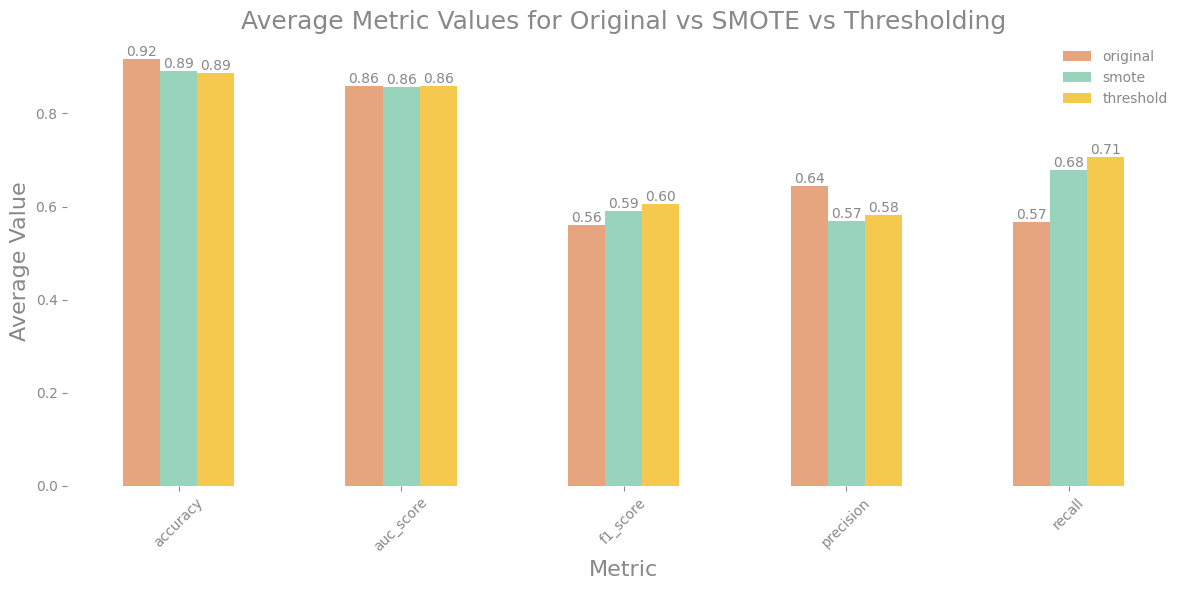

In [9]:
# Function to apply the global chart configuration
def apply_chart_cfg(ax):
    ax.spines['top'].set_visible(chart_cfg['border_visible'])
    ax.spines['right'].set_visible(chart_cfg['border_visible'])
    ax.spines['bottom'].set_visible(chart_cfg['border_visible'])
    ax.spines['left'].set_visible(chart_cfg['border_visible'])
    
    ax.set_facecolor("none")
    
    ax.set_title(ax.get_title(), color=chart_cfg['font_color'], fontsize=chart_cfg['title_font_size'])
    ax.set_xlabel(ax.get_xlabel(), color=chart_cfg['font_color'], fontsize=chart_cfg['xlabel_font_size'])
    ax.set_ylabel(ax.get_ylabel(), color=chart_cfg['font_color'], fontsize=chart_cfg['ylabel_font_size'])
    
    ax.tick_params(axis='x', colors=chart_cfg['font_color'], labelsize=chart_cfg['tick_font_size'])
    ax.tick_params(axis='y', colors=chart_cfg['font_color'], labelsize=chart_cfg['tick_font_size'])

    if chart_cfg['transparency']:
        ax.patch.set_alpha(0)

plt.figure(figsize=(12, 6))
ax = avg_metrics.plot(kind='bar', color=[chart_cfg['colors']['original'], chart_cfg['colors']['smote'], chart_cfg['colors']['threshold']], figsize=(12, 6))

# Annotating bars with their rounded values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=chart_cfg['tick_font_size'],
                color=chart_cfg['font_color'])

plt.title('Average Metric Values for Original vs SMOTE vs Thresholding')
plt.ylabel('Average Value')
plt.xlabel('Metric')
legend = plt.legend(facecolor='none', edgecolor='none', fontsize=chart_cfg['tick_font_size'])
plt.setp(legend.get_texts(), color=chart_cfg['legend_font_color'])
plt.xticks(rotation=45)
apply_chart_cfg(plt.gca())
plt.tight_layout()
plt.show()



# % of Time Scenario is Better

In [10]:
comparison_counts = data[['model', 'dataset']].drop_duplicates().shape[0]
comparison_counts

465

## Overall across models and datasets

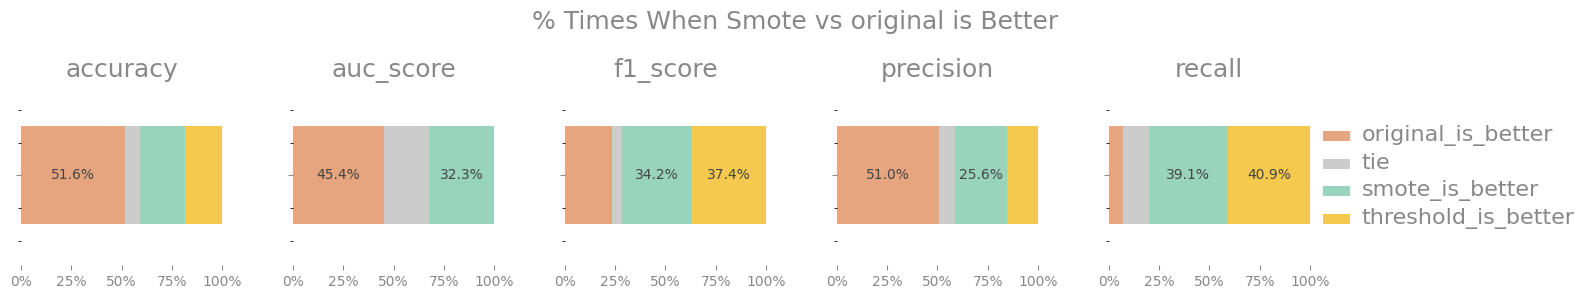

In [11]:
# Calculate the percentage of comparisons where SMOTE was better, original was better, or there was a tie for each metric
comparison_columns = ['original_is_better', 'tie', 'smote_is_better', 'threshold_is_better']
comparison_counts = data\
    .groupby('metric')['comparison']\
    .value_counts(normalize=True)\
    .unstack()\
    .loc[chart_cfg['ordered_metrics']]

comparison_counts = comparison_counts[comparison_columns]

# Create sub-plots with 5 columns (one for each metric) and 1 row
fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharey=True)

# Plot each subplot
for ax, metric in zip(axes, chart_cfg['ordered_metrics']):
    comparison_counts\
        .loc[[metric]][comparison_columns]\
        .plot(
            kind='barh',
            stacked=True,
            color=[
                    chart_cfg['colors']['original'],
                    chart_cfg['colors']['tie'],
                    chart_cfg['colors']['smote'],
                    chart_cfg['colors']['threshold']
            ],
            ax=ax,
            legend=False,
            width=0.6
    )
    ax.set_title(metric, fontsize=chart_cfg['title_font_size'], color=chart_cfg['font_color'])
    # ax.set_xlabel('Percentage', fontsize=chart_cfg['xlabel_font_size'], color=chart_cfg['font_color'])
    ax.tick_params(axis='x', colors=chart_cfg['font_color'], labelsize=chart_cfg['tick_font_size'])
    ax.tick_params(axis='y', colors=chart_cfg['font_color'], labelsize=chart_cfg['tick_font_size'])
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(lambda x, _: f'{100*x:.0f}%')
    apply_chart_cfg(ax)
    ax.set_ylabel('')
    ax.set_yticklabels('')
    
    # Annotate each stack with its value
    for p in ax.patches:
        width = p.get_width()
        if width > 0.25:  # Displaying percentage only if it's greater than 25%
            ax.annotate(f"{width*100:.1f}%", 
                        (p.get_x() + width/2, p.get_y() + p.get_height()/2), 
                        ha='center', va='center', 
                        color='#444444',
                        fontsize=10)

plt.suptitle(
    '% Times When Smote vs original is Better',
    fontsize=chart_cfg['title_font_size'],
    color=chart_cfg['font_color']
)


# Adjust layout and show the plot
legend = axes[4]\
    .legend(
#         title='Scenario',
        bbox_to_anchor=(1.0, 0.85),
        facecolor='none',
        edgecolor='none',
        fontsize=chart_cfg['tick_font_size'],
        title_fontsize=chart_cfg['tick_font_size'],
#         color='#ccc'
    )

# Set font color for the legend text
for text in legend.get_texts():
    text.set_color(chart_cfg['legend_font_color'])
    text.set_fontsize(chart_cfg['legend_font_size'])
plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()
    

## Original vs Smote vs Thresholding For Each Model

In [12]:
# Calculate the mean and standard deviation for SMOTE and original scenarios for each model and metric
mean_smote = data.groupby(['model', 'metric'])['smote'].mean().unstack().round(3)
std_smote = data.groupby(['model', 'metric'])['smote'].std().unstack().round(3)

mean_original = data.groupby(['model', 'metric'])['original'].mean().unstack().round(3)
std_original = data.groupby(['model', 'metric'])['original'].std().unstack().round(3)

mean_threshold = data.groupby(['model', 'metric'])['threshold'].mean().unstack().round(3)
std_threshold = data.groupby(['model', 'metric'])['threshold'].std().unstack().round(3)

df_smote = mean_smote.copy()
for metric in chart_cfg['ordered_metrics']:
    df_smote[metric] = \
        mean_smote[metric].round(3).astype(str) + "+/-" + \
        std_smote[metric].round(3).astype(str)

df_smote.insert(0, 'source', "smote")
#print(df_smote.head())

df_original = mean_original.copy()
for metric in chart_cfg['ordered_metrics']:
    df_original[metric] = \
        mean_original[metric].round(3).astype(str) + "+/-" + \
        std_original[metric].round(3).astype(str)

df_original.insert(0, 'source', "original")

df_threshold = mean_threshold.copy()
for metric in chart_cfg['ordered_metrics']:
    df_threshold[metric] = \
        mean_threshold[metric].round(3).astype(str) + "+/-" + \
        std_threshold[metric].round(3).astype(str)
    
df_threshold.insert(0, 'source', "threshold")
# Combine the dataframes with multi-level index
table = pd.concat([df_smote.reset_index(), df_original.reset_index(), df_threshold.reset_index()], axis=0, ignore_index=True)

# Convert 'model' column to Categorical with a custom order
table['model'] = pd.Categorical(table['model'], categories=chart_cfg['ordered_models'], ordered=True)

# Set the multi-index and sort
table_sorted = table.set_index(['model', 'source']).sort_index()
table_sorted

metric                                       accuracy      auc_score  \
model                        source                                    
naive_bayes                  original   0.759+/-0.245  0.805+/-0.137   
                             smote      0.716+/-0.223  0.804+/-0.126   
                             threshold  0.759+/-0.245  0.805+/-0.137   
logistic_regression          original    0.93+/-0.054  0.867+/-0.132   
                             smote      0.829+/-0.126   0.867+/-0.13   
                             threshold  0.811+/-0.151  0.867+/-0.132   
k_nearest_neighbors          original   0.931+/-0.062  0.818+/-0.148   
                             smote      0.865+/-0.114  0.824+/-0.151   
                             threshold    0.9+/-0.109  0.818+/-0.148   
adaboost                     original   0.848+/-0.119   0.876+/-0.13   
                             smote      0.848+/-0.119   0.877+/-0.13   
                             threshold  0.833+/-0.138   0.876+/-0.13   
decision_tree                original   0.918+/-0.079  0.759+/-0.161   
                             smote      0.909+/-0.084  0.767+/-0.166   
                             threshold  0.918+/-0.078  0.759+/-0.161   
support_vector_classifier    original   0.938+/-0.057  0.837+/-0.176   
                             smote      0.887+/-0.111  0.864+/-0.156   
                             threshold   0.88+/-0.191  0.837+/-0.176   
artificial_neural_network    original   0.937+/-0.059  0.866+/-0.152   
                             smote      0.901+/-0.101  0.854+/-0.155   
                             threshold  0.906+/-0.093  0.866+/-0.152   
multi_layer_perceptron       original   0.935+/-0.063  0.871+/-0.142   
                             smote      0.906+/-0.094  0.851+/-0.162   
                             threshold  0.916+/-0.083  0.871+/-0.142   
explainable_boosting_machine original   0.927+/-0.073  0.866+/-0.148   
                             smote      0.927+/-0.073  0.866+/-0.148   
                             threshold   0.91+/-0.111  0.866+/-0.148   
extra_trees                  original    0.938+/-0.06  0.889+/-0.135   
                             smote      0.933+/-0.064  0.888+/-0.134   
                             threshold  0.894+/-0.111  0.889+/-0.135   
random_forest                original   0.942+/-0.058  0.889+/-0.132   
                             smote      0.935+/-0.065  0.889+/-0.134   
                             threshold  0.903+/-0.115  0.889+/-0.132   
stacking_classifier          original   0.944+/-0.059    0.9+/-0.125   
                             smote      0.934+/-0.068  0.869+/-0.154   
                             threshold  0.923+/-0.089    0.9+/-0.125   
catboost                     original   0.944+/-0.056  0.894+/-0.132   
                             smote      0.915+/-0.089  0.884+/-0.142   
                             threshold  0.915+/-0.098  0.894+/-0.132   
lightgbm                     original   0.942+/-0.059  0.881+/-0.134   
                             smote      0.934+/-0.067   0.874+/-0.14   
                             threshold   0.916+/-0.11  0.881+/-0.134   
xgboost                      original    0.932+/-0.07  0.869+/-0.154   
                             smote      0.931+/-0.071  0.869+/-0.154   
                             threshold  0.914+/-0.097  0.869+/-0.154   

metric                                       f1_score      precision  \
model                        source                                    
naive_bayes                  original   0.396+/-0.219  0.349+/-0.231   
                             smote      0.363+/-0.217    0.3+/-0.244   
                             threshold  0.396+/-0.219  0.349+/-0.231   
logistic_regression          original    0.448+/-0.36  0.634+/-0.344   
                             smote        0.52+/-0.24  0.424+/-0.261   
                             threshold  0.521+/-0.251  0.412+/-0.262   
k_nearest_neighbors          original  

In [13]:
table_sorted.to_csv("./results/results-mean-stddev.csv")

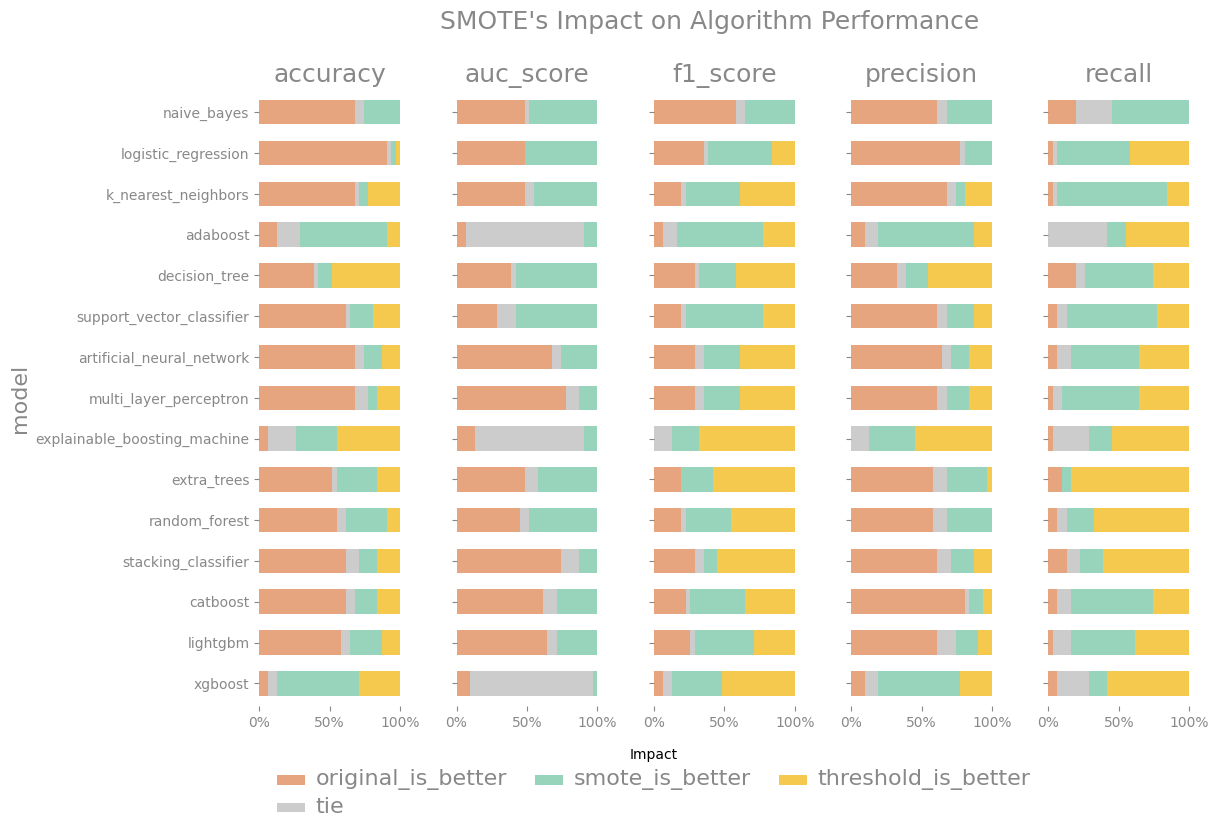

In [14]:
# Calculate the percentage of comparisons where SMOTE was better, original was better, or there was a tie for each metric and model
comparison_counts_model = data.groupby(['metric', 'model'])['comparison'].value_counts(normalize=True).unstack().fillna(0)
comparison_columns = ['original_is_better', 'tie', 'smote_is_better', 'threshold_is_better']

# comparison_counts_model

# Create sub-plots with 5 columns (one for each metric) and 1 row
fig, axes = plt.subplots(1, 5, figsize=(12, 8), sharey=True)

for col, metric in enumerate(chart_cfg['ordered_metrics']):  
    ax = axes[col]
    df = comparison_counts_model.loc[metric]
    df = df.reindex(chart_cfg['ordered_models'][::-1])
    df[comparison_columns].plot(
        kind='barh',
        stacked=True,
        ax=ax,        
        color=[
            chart_cfg['colors']['original'],
            chart_cfg['colors']['tie'],
            chart_cfg['colors']['smote'],
            chart_cfg['colors']['threshold']
        ],
        legend=False,
        width=0.6
    )
    ax.set_xlim(0, 1)
    ax.set_title(metric, fontsize=chart_cfg['title_font_size'], color=chart_cfg['font_color'])
    ax.xaxis.set_major_formatter(lambda x, _: f'{100*x:.0f}%')
    ax.tick_params(axis='x', colors=chart_cfg['font_color'], labelsize=chart_cfg['tick_font_size'])
    ax.tick_params(axis='y', colors=chart_cfg['font_color'], labelsize=chart_cfg['tick_font_size'])
    apply_chart_cfg(ax)

plt.suptitle(
    "SMOTE's Impact on Algorithm Performance",
    fontsize=chart_cfg['title_font_size'],
    color=chart_cfg['font_color']
)

# Adjust layout and show the plot
legend = axes[2]\
    .legend(
        title='Impact',
        bbox_to_anchor=(0.0, -0.2),
        loc='lower center',
        facecolor='none',
        edgecolor='none',
        fontsize=chart_cfg['tick_font_size'],
        title_fontsize=chart_cfg['tick_font_size'],
        ncol=3
    )
# Set font color for the legend text
for text in legend.get_texts():
    text.set_color(chart_cfg['legend_font_color'])
    text.set_fontsize(chart_cfg['legend_font_size'])
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

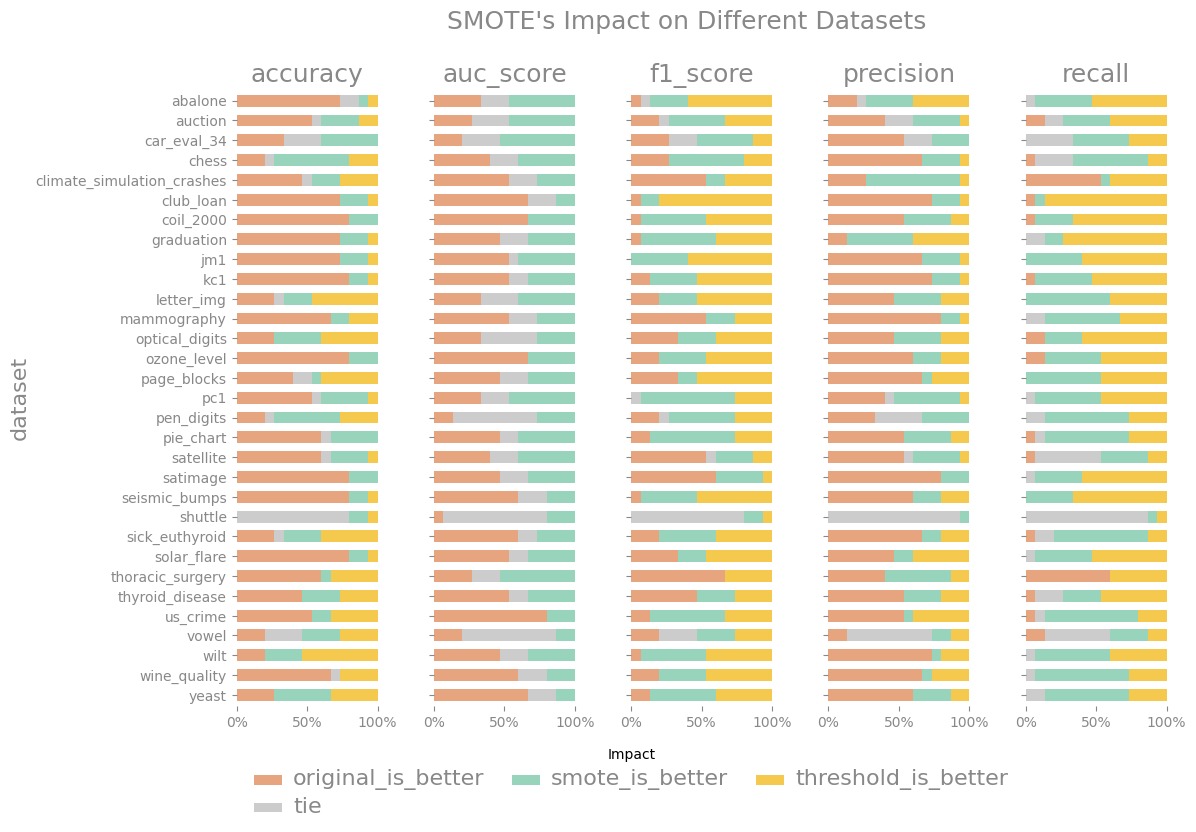

In [15]:
# Calculate the percentage of comparisons where SMOTE was better, original was better, 
# or there was a tie for each metric and dataset
datasets = data['dataset'].unique()
comparison_counts_dataset = data.groupby(['metric', 'dataset'])['comparison'].value_counts(normalize=True).unstack().fillna(0)
# comparison_counts_model

# Create sub-plots with 5 columns (one for each metric) and 1 row
fig, axes = plt.subplots(1, 5, figsize=(12, 8), sharey=True)

for col, metric in enumerate(chart_cfg['ordered_metrics']):  
    ax = axes[col]
    df = comparison_counts_dataset.loc[metric]
    df = df.reindex(datasets[::-1])
    df[comparison_columns].plot(
        kind='barh',
        stacked=True,
        ax=ax,        
        color=[
            chart_cfg['colors']['original'],
            chart_cfg['colors']['tie'],
            chart_cfg['colors']['smote'],
            chart_cfg['colors']['threshold']
        ],
        legend=False,
        width=0.6
    )
    ax.set_xlim(0, 1)
    ax.set_title(metric, fontsize=chart_cfg['title_font_size'], color=chart_cfg['font_color'])
    ax.xaxis.set_major_formatter(lambda x, _: f'{100*x:.0f}%')
    ax.tick_params(axis='x', colors=chart_cfg['font_color'], labelsize=chart_cfg['tick_font_size'])
    ax.tick_params(axis='y', colors=chart_cfg['font_color'], labelsize=chart_cfg['tick_font_size'])
    apply_chart_cfg(ax)

plt.suptitle(
    "SMOTE's Impact on Different Datasets",
    fontsize=chart_cfg['title_font_size'],
    color=chart_cfg['font_color']
)

# Adjust layout and show the plot
legend = axes[2]\
    .legend(
        title='Impact',
        bbox_to_anchor=(0.0, -0.2),
        loc='lower center',
        facecolor='none',
        edgecolor='none',
        fontsize=chart_cfg['tick_font_size'],
        title_fontsize=chart_cfg['tick_font_size'],
        ncol=3
    )
# Set font color for the legend text
for text in legend.get_texts():
    text.set_color(chart_cfg['legend_font_color'])
    text.set_fontsize(chart_cfg['legend_font_size'])
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

In [16]:
2.51 * 10**-3 == 2.52**-4

False